# TODO
 - Batch norm?
 - Figure out batch size
 - Clean up the UNet itself haha lol
 - Rewrite to be able to use Google Colab, test if faster
 - Save model hparam to a file when running a model, to use for reference
 - Show prediction image in Tensorboard

# Semantic Segmentation of car images

In this notebook, we will design a semantic segmentation model using the CamVid dataset

## Setup

The following cells will import important packages, configure devices, load TensorBoard etc

In [555]:
import sys
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [556]:
# Set up device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device being used: {device}")

device being used: cpu


In [557]:
# Set up Matplotlib

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [558]:
# Some small fixes to prevent Jupyter from bugging out

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# To prevent the kernel from dying.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [559]:
# Set up TensorBoard

""" Personal notes on superbuggy VSCode tensorboard

The general conclusion I have is that Tensorboard in VSCode breaks regularly for whatever reasons, and nobody
cares to fix it. So just use Tensboard from the browser. Code below will run tensorboard on port 6006

For some reason tensorboard isn't quitting properly, and keeps the port occupied even
if the process itself is killed.

1. Check Code Python Interpreter is i2dl

2. Check if port occupied:
lsof -i:6006

Kill using the PID from above command (not 6006, the PID!):
kill PID

See https://stackoverflow.com/questions/54395201/tensorboard-could-not-bind-to-port-6006-it-was-already-in-use
Also, see this on how to kill tensorboard process (but not the problem here): https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server

3. Alternative if I want to see tensorboard in a webbrowser (6006, 8888 etc):
tensorboard --logdir=data/ --host localhost --port 6006
http//localhost:6006

Another possible bug is that installing tensorboard with conda is not visible in Jupyter Notebooks using VSCode. You will have to reinstall it using pip instead

"""

%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=logs/ --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14742), started 2:03:19 ago. (Use '!kill 14742' to kill it.)

# Download and prepare dataset

## CityScape Dataset

The CityScape dataset will not download automatically with Torchvision. Instead, you will have to download it from their [website](https://www.cityscapes-dataset.com/) by signing up and downloading the *gtFine* and *leftImg8bit* datasets, and placing them in ```root/data/cityscapes``` folder in the root directory of this repository.

Sadly, the CityScapes Class in Torchvision is a bit lacking for our use case.
- Does not seem to accept slice indexes, so we will have to write our own little version on top of it which fixes the ```__getitem__``` method. That way, we can do something like ```train_dataset[0:3]``` and not just ```train_dataset[1]```
- We want to work directly on image tensors, and not a PIL Image object, because we don't need all of the extra stuff that comes with it.
- Our target is passed to ```nn.CrossEntropyLoss()``` when calculating the loss, and needs to be of type ```long``` not ```float```

Also, applying our model on the full resolution images would be very long, so we will reduce the image resolution for both input and output images

Note that when we do the actual training, we do not use the dataset class directly: we use PyTorch's built in Dataloader class, which speeds up batch processing.

In [560]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torchvision.datasets import Cityscapes
from torchvision import transforms as vision_tf
from PIL.Image import Resampling

""" TODO: 
- Type annotations would be really nice here
- Check if we can make things faster, dataloading is always a bottleneck
- One day, should completely rewrite this class so it is actually fast
"""

# Downsize the input images, as HD images are too large and training would take forever. Use a power of 2, bigger if you want
# training to be faster
SCALING_FACTOR = 16


class FixedCityScapes(Cityscapes):
    def __init__(
        self,
        root: str,
        split: str = "train",
        mode: str = "fine",
        target_type: List[str] | str = "instance",
        transform: Callable[..., Any] | None = None,
        target_transform: Callable[..., Any] | None = None,
        transforms: Callable[..., Any] | None = None,
    ) -> None:
        super().__init__(
            root, split, mode, target_type, transform, target_transform, transforms
        )

        self.scaled_w: int = 2048 // SCALING_FACTOR
        self.scaled_h: int = 1024 // SCALING_FACTOR

        assert (
            np.log2(self.scaled_w).is_integer() and np.log2(self.scaled_h).is_integer()
        ), "SCALING_FACTOR does not result in width and height being powers of 2"

        # This will convert an RGB image to a tensor with value [0,1], i.e. rescales!
        self.to_tensor = vision_tf.ToTensor()

    def __getitem__(self, key) -> Tuple[Any, Any]:
        if isinstance(key, slice):
            # This will take the start, stop and step of the slice
            # self[i] will return the below isinstance(key, int) logic
            return [self[i] for i in range(*key.indices(len(self)))]
        elif isinstance(key, int):
            raw = super().__getitem__(key)
            if self.split in ("train", "val"):
                # Returns Tuple[Image, Tuple[Segmentation Mask, Colored Mask]]
                data = (
                    self.to_tensor(
                        raw[0].resize(
                            (self.scaled_w, self.scaled_h), Resampling.NEAREST
                        )
                    ),
                    (
                        torch.from_numpy(
                            np.array(
                                raw[1][0].resize(
                                    (self.scaled_w, self.scaled_h), Resampling.NEAREST
                                ),
                                dtype=np.int64,
                            )
                        ),
                        torch.from_numpy(
                            np.array(
                                raw[1][1].resize(
                                    (self.scaled_w, self.scaled_h), Resampling.NEAREST
                                ),
                                dtype=np.int64,
                            )
                        ),
                    ),
                )
            elif self.split == "test":
                # Returns Tuple[Image, Empty Segmentation Mask]
                raw = super().__getitem__(key)
                data = (
                    self.to_tensor(
                        raw[0].resize(
                            (self.scaled_w, self.scaled_h), Resampling.NEAREST
                        )
                    ),
                    torch.from_numpy(
                        np.array(
                            raw[1].resize(
                                (self.scaled_w, self.scaled_h), Resampling.NEAREST
                            ),
                            dtype=np.int64,
                        )
                    ),  # This is empty image and pretty useless
                )
            else:
                raise KeyError(f"Type of split is not known: {self.split}")
            return data
        else:
            raise TypeError(f"Invalid argument type (key is of type {type(key)})")

In [561]:
from torchvision.datasets import Cityscapes

# https://pytorch.org/vision/0.15/generated/torchvision.datasets.Cityscapes.html#torchvision.datasets.Cityscapes
# https://stackoverflow.com/questions/56650201/how-to-convert-35-classes-of-cityscapes-dataset-to-19-classes
# https://www.cityscapes-dataset.com/downloads/

# TODO: Augmentations and transforms

print("Loading training dataset")
train_dataset = FixedCityScapes(
    root="data/cityscapes",
    split="train",
    mode="fine",
    target_type=["semantic", "color"],
)
print("Loading validation dataset")
val_dataset = FixedCityScapes(
    root="data/cityscapes", split="val", mode="fine", target_type=["semantic", "color"]
)
print("Loading test dataset")
test_dataset = FixedCityScapes(
    root="data/cityscapes", split="test", mode="fine", target_type="semantic"
)  # Test data is unlabeled, so semantic target is simply black
print("Done loading datasets")

Loading training dataset
Loading validation dataset
Loading test dataset
Done loading datasets


In [562]:
# Show some basic information about the dataset

print("Train size: %i" % len(train_dataset))
print("Validation size: %i" % len(val_dataset))
print("Test size: %i" % len(test_dataset))

# Dataset returns a tuple of PIL Images, input image and segmented groundtruth
# https://pillow.readthedocs.io/en/stable/reference/Image.html#image-attributes
first_image = train_dataset[0]
print(f"Image dimensions: {first_image[0].shape}")
print(f"Target mask dimensions: {first_image[1][0].shape}")
print(
    f"Target tuple size: {len(first_image[1])}"
)  # items called from the dataset are a tuple, first item is input image, second is another tuple with targets

# test_dataset[0]

Train size: 2975
Validation size: 500
Test size: 1525
Image dimensions: torch.Size([3, 64, 128])
Target mask dimensions: torch.Size([64, 128])
Target tuple size: 2


In [563]:
# Function to visualize data
from torch import Tensor


def visualize_imgs(images):
    if isinstance(images[0], Tensor):
        plt.figure(figsize=(20, 6))

        # Input image
        plt.subplot(1, 3, 1)
        plt.imshow(images[0].numpy().transpose(1, 2, 0))
        plt.axis("off")
        plt.title("Input image")

        # Colored Ground truth segmented image
        # Input image
        plt.subplot(1, 3, 2)
        plt.imshow(images[1][1].numpy())
        plt.axis("off")
        plt.title("Ground Truth (colored)")

        # Ground truth using ids (so basically shades of grey)
        # Input image
        plt.subplot(1, 3, 3)
        plt.imshow(images[1][0].numpy())
        plt.axis("off")
        plt.title("Ground Truth (ids)")
    else:
        n = len(images)
        plt.figure(figsize=(20, 6 * n))
        for i, (img, target) in enumerate(images):
            # Input image
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.axis("off")
            if i == 0:
                plt.title("Input image")

            # Colored Ground truth segmented image
            # Input image
            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(target[1].numpy())
            plt.axis("off")
            if i == 0:
                plt.title("Ground Truth (colored)")

            # Ground truth using ids (so basically shades of grey)
            # Input image
            plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(target[0].numpy())
            plt.axis("off")
            if i == 0:
                plt.title("Ground Truth (IDs)")

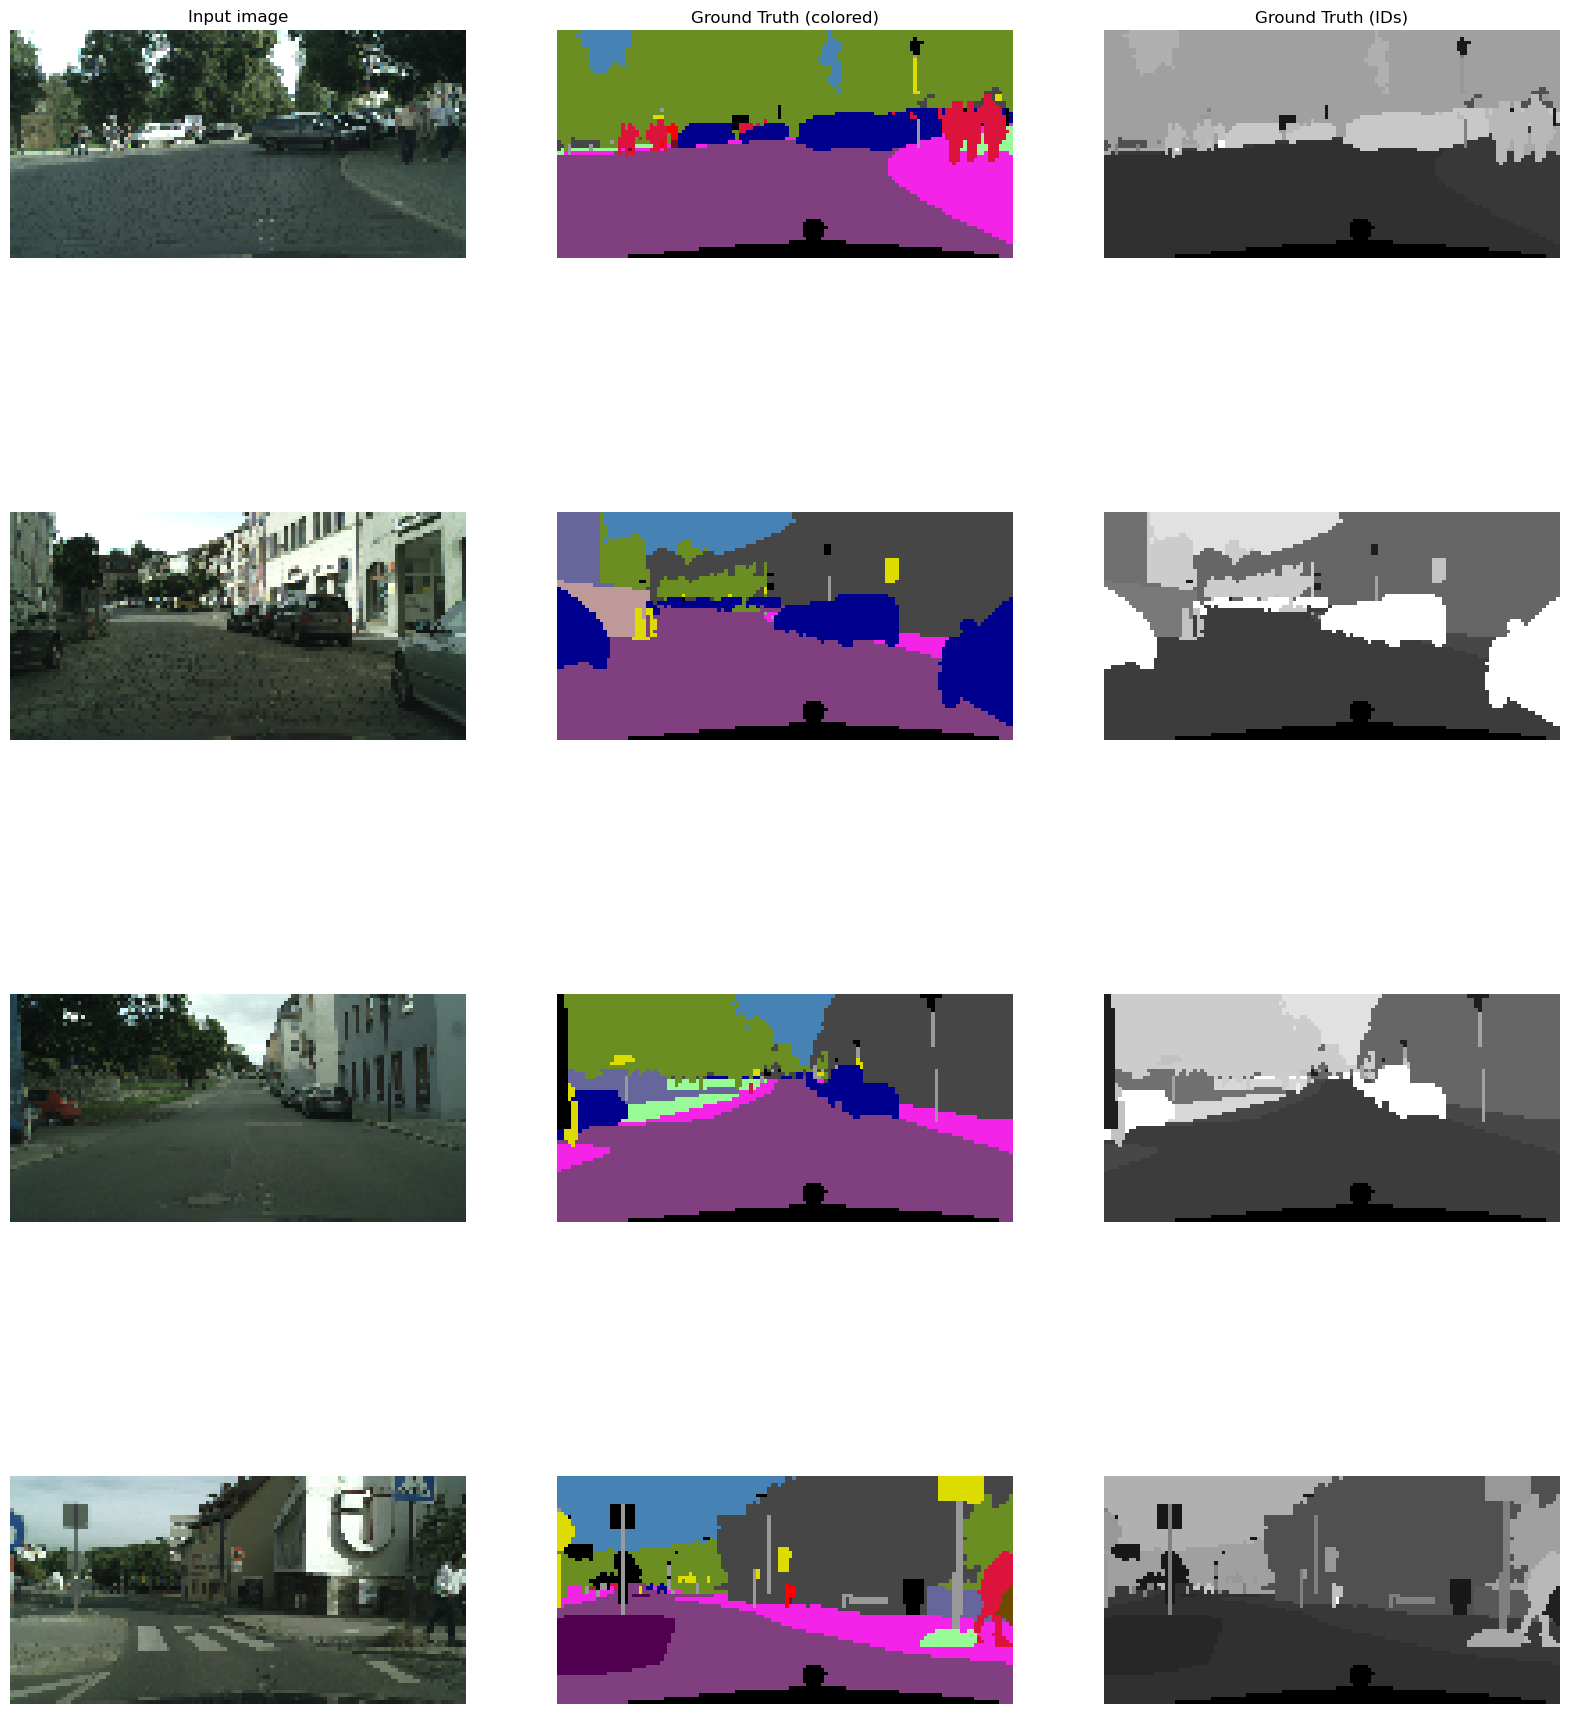

In [564]:
# Show some of the dataset

num_example_imgs = 4
visualize_imgs(train_dataset[0:num_example_imgs])

TODO:

- Create model
- Create tensor that uses one hot encoding for ids, not just a flat image
- Use a UNet
- Create trainer (use dataloader, load to device)
- Use a good loss function

# Design of Segmentation Model

In [565]:
# Helper Classes


class ConvSandwich(nn.Module):
    """
    Helper Class that creates a Convolution Layer with a BatchNorm Layer and Activation layer
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=False
        )  # Because we use Batchnorm, bias is averaged out, so don't use
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x


class PrintLayer(nn.Module):
    """
    Helper Class for debugging behaviour of model. Will print out the shape of the layer input,
    and input passed directly to output
    """

    def forward(self, x):
        print(x.shape)
        return x


def weights_init(m):
    """
    Initialize weights for each layer of model m, based on the type of activation function
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

In [566]:
# Encoder and Decoder

"""
TODO:
- Optimizer only train encoder of decoder
- Make my own model
- Use PyTorch optimizations from their guide: 
"""


class SegmentationNN(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hp = hparams
        self.kernel_factor = self.hp[
            "kernel_factor"
        ]  # Reuse this value often, so don't search a Dict

        """"
        General structure of the model:
        
        - encoder_block downsamples inputs and learns key features. Intermediate outputs are stored
        and used by the decoder block
        - decoder_block: Upsamples the low dimensional outputs of the encoder_block, essentially
        'learns' how things should look, and reconstructs the full segmented image
        - classifier 
        """
        self.encoder = nn.ModuleList(
            [
                ConvSandwich(
                    3, self.kernel_factor, 3, 1, 1
                ),  # RGB image input has 3 channels
                ConvSandwich(self.kernel_factor, self.kernel_factor * 2, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 2, self.kernel_factor * 4, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 4, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 8, 3, 1, 1),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                ConvSandwich(
                    self.kernel_factor * (8 + 8), self.kernel_factor * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.kernel_factor * (4 + 4), self.kernel_factor * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.kernel_factor * (4 + 4), self.kernel_factor * 2, 3, 1, 1
                ),
                ConvSandwich(self.kernel_factor * (2 + 2), self.kernel_factor, 3, 1, 1),
            ]
        )

        self.classifier = nn.Conv2d(
            self.kernel_factor * 2 + 3, self.hp["output_size"], kernel_size=3, padding=1
        )

        self.downsample = nn.MaxPool2d(
            kernel_size=2, stride=2
        )  # Layer reused for downsampling
        self.upsample = nn.Upsample(
            scale_factor=2, mode="bicubic"
        )  # Layer reused for upsampling

        # self.print = PrintLayer()  # Used for debugging

        self.device = hparams.get(
            "device", torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
        self.set_optimizer()

        # Apply initial weights
        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.classifier.apply(weights_init)

    def forward(self, x):
        # Unet network

        # Note: need to use multiples of 2 or else rounding makes torch.cat try to concat tensors
        # of different sizes

        proc_x = self.encoder[0](x)
        enc_1 = self.encoder[1](proc_x)
        tmp = self.downsample(enc_1)
        enc_2 = self.encoder[2](tmp)
        tmp = self.downsample(enc_2)
        enc_3 = self.encoder[3](tmp)
        tmp = self.downsample(enc_3)
        enc_4 = self.encoder[4](tmp)

        bottleneck = self.downsample(enc_4)

        tmp = self.upsample(bottleneck)
        dec = self.decoder[0](torch.cat([tmp, enc_4], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[1](torch.cat([tmp, enc_3], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[2](torch.cat([tmp, enc_2], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[3](torch.cat([tmp, enc_1], dim=1))
        tmp = self.upsample(dec)

        dec = torch.cat([dec, proc_x], dim=1)
        dec = torch.cat([dec, x], dim=1)
        x = self.classifier(dec)

        return x

    def set_optimizer(self):
        self.optimizer = None

        self.optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hp["learning_rate"],
            weight_decay=self.hp["weight_decay"],
        )

    def training_step(self, batch, loss_func):
        self.train()
        self.optimizer.zero_grad()  # Reset gradient every batch

        # N = batch size, C = channels (3 for RGB), H = image height, W = image width
        images = batch[0].to(self.device)  # Input batch, N x C x H x W
        target = (
            batch[1][0].to(self.device).squeeze()
        )  # Ground truth, each pixel assigned an ID int. N x H x W

        # Model makes prediction (forward pass)
        pred = self.forward(images)  # N x C x H x W (C=num of CityScape classes)

        # Calculate loss, do backward pass to update weights, optimizer takes step
        # torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean") wants target to be of type long, not float
        loss = loss_func(pred, target)
        loss.backward()
        self.optimizer.step()

        return loss

    def validation_step(self, batch, loss_func):
        loss = 0

        # Set model to eval
        self.eval()

        with torch.no_grad():
            images = batch[0].to(self.device)  # Input batch, N x C x H x W
            target = (
                batch[1][0].to(self.device).squeeze()
            )  # Ground truth, each pixel assigned an ID int. N x H x W

            pred = self.forward(images)
            loss = loss_func(pred, target)

        return loss

# Train Model

In [567]:
# Hyperparameters

hparams = {
    "device": device,
    "num_workers": 8,
    "epochs": 20,
    "batch_size": 64,
    "kernel_factor": 64,  # Multiplied by powers of 2 to create number of kernels in Conv layers
    "max_patience": 3,
    "input_size": np.array((2048, 1024))
    // SCALING_FACTOR,  # Scaled image resolution (tuple), variable not used by actual model since CNN
    "output_size": len(Cityscapes.classes),  # Classes in CityScape, should be 35
    "learning_rate": 1e-3,
    "weight_decay": 1e-8,
}

Since this is just for demonstration purposes, let us make sure the model is not too big. We want to be able to run it on something like a CPU even if we don't have access to a GPU! A parameter size of 25MB seems to be good enough to get this model working on a mid tier desktop CPU.

In [568]:
from torchinfo import summary

model = SegmentationNN(hparams=hparams)
summary(
    model,
    input_size=(
        hparams["batch_size"],
        3,
        hparams["input_size"][0],
        hparams["input_size"][1],
    ),
)

Layer (type:depth-idx)                   Output Shape              Param #
SegmentationNN                           [64, 35, 128, 64]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ConvSandwich: 2-1                 [64, 64, 128, 64]         --
│    │    └─Conv2d: 3-1                  [64, 64, 128, 64]         1,728
│    │    └─BatchNorm2d: 3-2             [64, 64, 128, 64]         128
│    │    └─LeakyReLU: 3-3               [64, 64, 128, 64]         --
│    └─ConvSandwich: 2-2                 [64, 128, 128, 64]        --
│    │    └─Conv2d: 3-4                  [64, 128, 128, 64]        73,728
│    │    └─BatchNorm2d: 3-5             [64, 128, 128, 64]        256
│    │    └─LeakyReLU: 3-6               [64, 128, 128, 64]        --
├─MaxPool2d: 1-2                         [64, 128, 64, 32]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ConvSandwich: 2-3                 [64, 256, 64, 32]

In [569]:
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)


def train_model(
    model, train_loader, val_loader, loss_func, tb_logger, epochs=3, name="segmentation"
):
    optimizer = model.optimizer

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7
    )

    validation_loss = 0
    model = model.to(device)

    patience = model.hp["max_patience"]
    best_val_loss = 10e10

    for epoch in range(epochs):
        # Training
        training_loop = create_tqdm_bar(
            train_loader, desc=f"Training Epoch [{epoch + 1}/{epochs}]"
        )
        training_loss = 0
        for train_iter, batch in training_loop:
            loss = model.training_step(batch, loss_func)
            training_loss += loss.item()
            scheduler.step()

            # Update progress bar
            training_loop.set_postfix(
                train_loss="{:.8f}".format(training_loss / (train_iter + 1)),
                lr="{:.8f}".format(optimizer.param_groups[0]["lr"]),
            )
            tb_logger.add_scalar(
                f"{name}/train_loss",
                loss.item(),
                epoch * len(train_loader) + train_iter,
            )

        # Validation
        val_loop = create_tqdm_bar(
            val_loader, desc=f"Validation Epoch [{epoch + 1}/{epochs}]"
        )
        validation_loss = 0
        with torch.no_grad():  # Don't actually need because validation_step already has it?
            for val_iter, batch in val_loop:
                loss = model.validation_step(batch, loss_func)
                validation_loss += loss.item()

                # Update the progress bar
                val_loop.set_postfix(
                    patience="{}".format(patience),
                    val_loss="{:.8f}".format(validation_loss / (val_iter + 1)),
                )

                # Update the tensorboard logger.
                tb_logger.add_scalar(
                    f"{name}/val_loss",
                    validation_loss / (val_iter + 1),
                    epoch * len(val_loader) + val_iter,
                )

        scaled_loss = validation_loss / (
            val_iter + 1
        )  # validation_loss is sum of batch losses, we want average
        if scaled_loss <= best_val_loss:
            patience = model.hp["max_patience"]
            best_val_loss = scaled_loss  # Rescaled based on batch size
        else:
            patience -= 1

        # End program if patience is done
        if patience == 0:
            print(f"Stopping early at epoch {epoch}! (patience done)")
            print(f"Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}")
            break

        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)
    print(f"Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}")

We do not want to use the dataset object directly during training, as this is slow. Instead, PyTorch provides a DataLoader class that speeds stuff up when we use batches of data. It even shuffles our training data for us!

In [570]:
from torch.utils.data import DataLoader

model = SegmentationNN(hparams=hparams)

# Create the tb_logger
path = os.path.join("logs", "segmentation_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")
tb_logger = SummaryWriter(path)

# Train the model
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False)

epochs = hparams.get("epochs", 5)
loss_func = torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
train_model(
    model,
    train_loader,
    val_loader,
    loss_func,
    tb_logger,
    epochs=epochs,
    name="segmentation",
)

Training Epoch [1/20]:   0%|                                                                                                   | 0/47 [00:00<?, ?it/s]

Validation Epoch [11/20]: 100%|████████████████████████████████████████████████████████| 8/8 [01:09<00:00,  8.75s/it, patience=1, val_loss=0.68817593]

Stopping early at epoch 10! (patience done)
Best Val loss: 0.6171550564467907. Final Val loss used: 0.6881759315729141
Best Val loss: 0.6171550564467907. Final Val loss used: 0.6881759315729141


In [571]:
# Save and load model. Saving and loading not part of the class because it makes pickling unreliable


def save(model, path, file_name):
    print(f"Saving the model to '{path}' folder")
    model = model.cpu()
    os.makedirs(path, exist_ok=True)
    model_path = os.path.join(
        path, file_name + ".pt"
    )  # File ending .pt for 'PyTorch' model
    torch.save(model, model_path)
    return model_path


def load(path):
    model = torch.load(path)
    model.eval()
    print(f"Loading the model at '{path}'")
    return model

In [572]:
save(model, path="models", file_name="segmentation_unet")

# model = load("models/segmentation_unet.pt")

Saving the model to 'models' folder


'models/segmentation_unet.pt'

In [573]:
def visualizer(model, device, test_data):
    n = len(test_data)
    plt.figure(figsize=(20, 6 * n))

    for i, (img, target) in enumerate(test_data):
        # Colored input image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(img.numpy().transpose(1, 2, 0))
        plt.axis("off")
        if i == 0:
            plt.title("Input image")

        # Prediction
        inputs = img.unsqueeze(0)
        inputs = inputs.to(device)
        outputs = model.forward(inputs)
        _, pred = torch.max(outputs, dim=1)
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(pred.numpy().squeeze())
        plt.axis("off")
        if i == 0:
            plt.title("Prediction (IDs)")

        # Ground truth
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(target[0])
        plt.axis("off")
        if i == 0:
            plt.title("Ground Truth (IDs)")

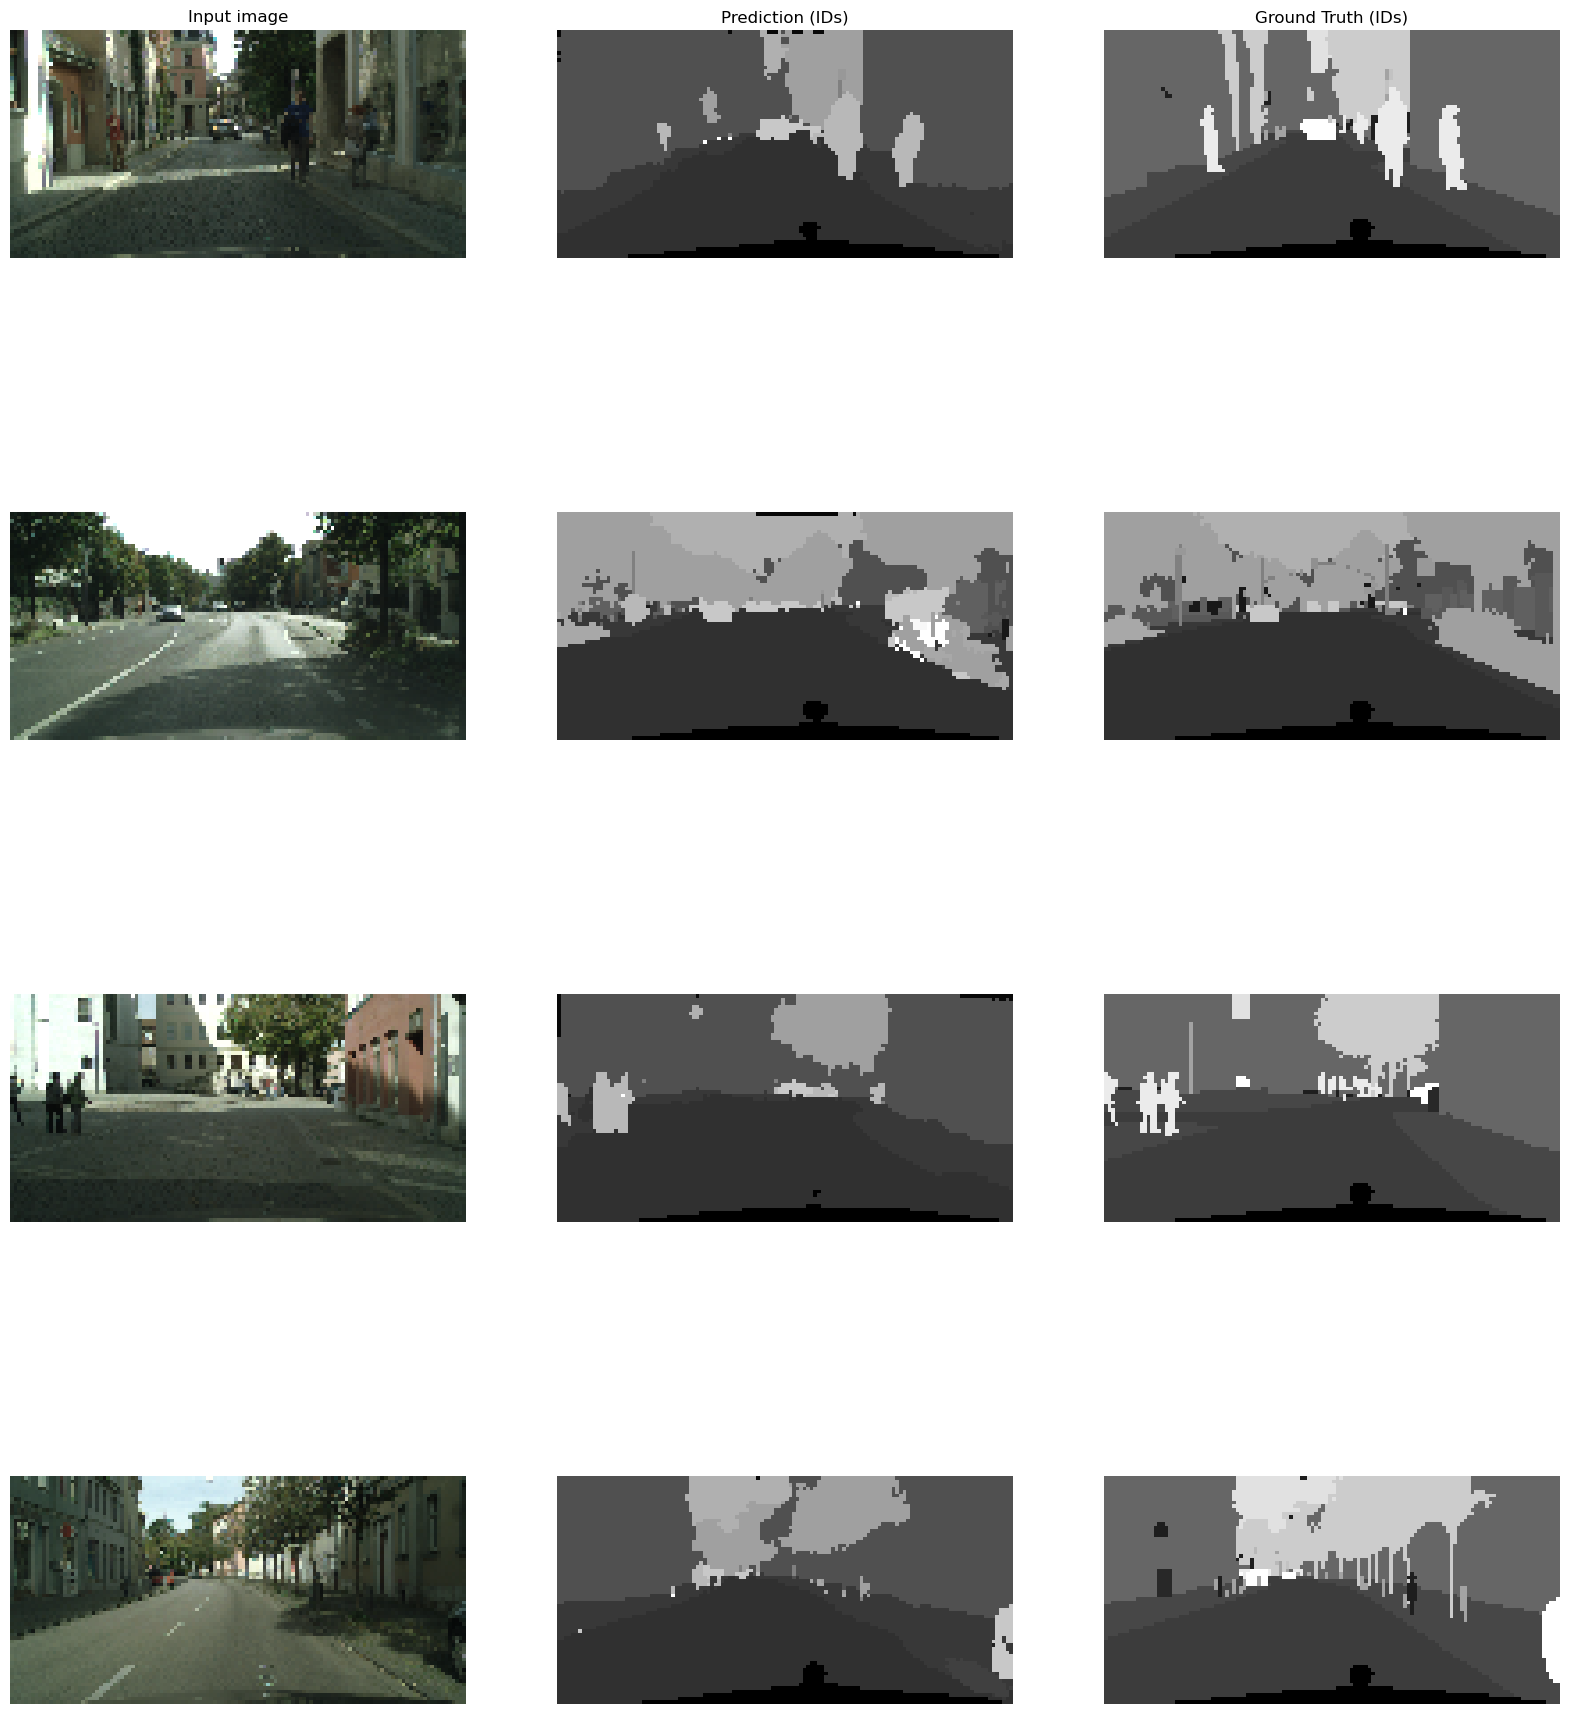

In [574]:
num_example_imgs = 4
visualizer(model, device, train_dataset[6 : num_example_imgs + 6])